In [1]:
from typing import AnyStr
import os
os.chdir("..")
os.chdir("src")
from data_cleaning import DataCleaning
import polars as pl
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from yellowbrick.text import FreqDistVisualizer
import matplotlib.pyplot as plt
import nltk
from unidecode import unidecode
import re
nltk.download('stopwords')
from nltk.corpus import stopwords
os.chdir("..")

[nltk_data] Downloading package stopwords to /home/bruno/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
cleaning_pipeline = DataCleaning()
df = cleaning_pipeline.run()

2024-03-28 00:29:20 - INFO - Data loaded!
2024-03-28 00:29:20 - INFO - Data types asserted!
2024-03-28 00:29:20 - INFO - Null values cleaned!
2024-03-28 00:29:20 - INFO - Full data cleaned!


## Checking the most common tokens

In [3]:
ds_objetos_array = df.select("DS_OBJETO").collect().to_numpy().flatten()

In [20]:
def frequencia_palavras(lista_texto, top_n=15, orient='v', figsize=(8, 6)):
    lista_texto = np.where(pd.isnull(lista_texto), '', lista_texto)

    vectorizer = CountVectorizer()
    docs = vectorizer.fit_transform(lista_texto)
    features = vectorizer.get_feature_names_out()

    fig, ax = plt.subplots(figsize=figsize)

    visualizer = FreqDistVisualizer(features=features, orient=orient, n=top_n, ax=ax)
    visualizer.fit(docs)
    visualizer.show()

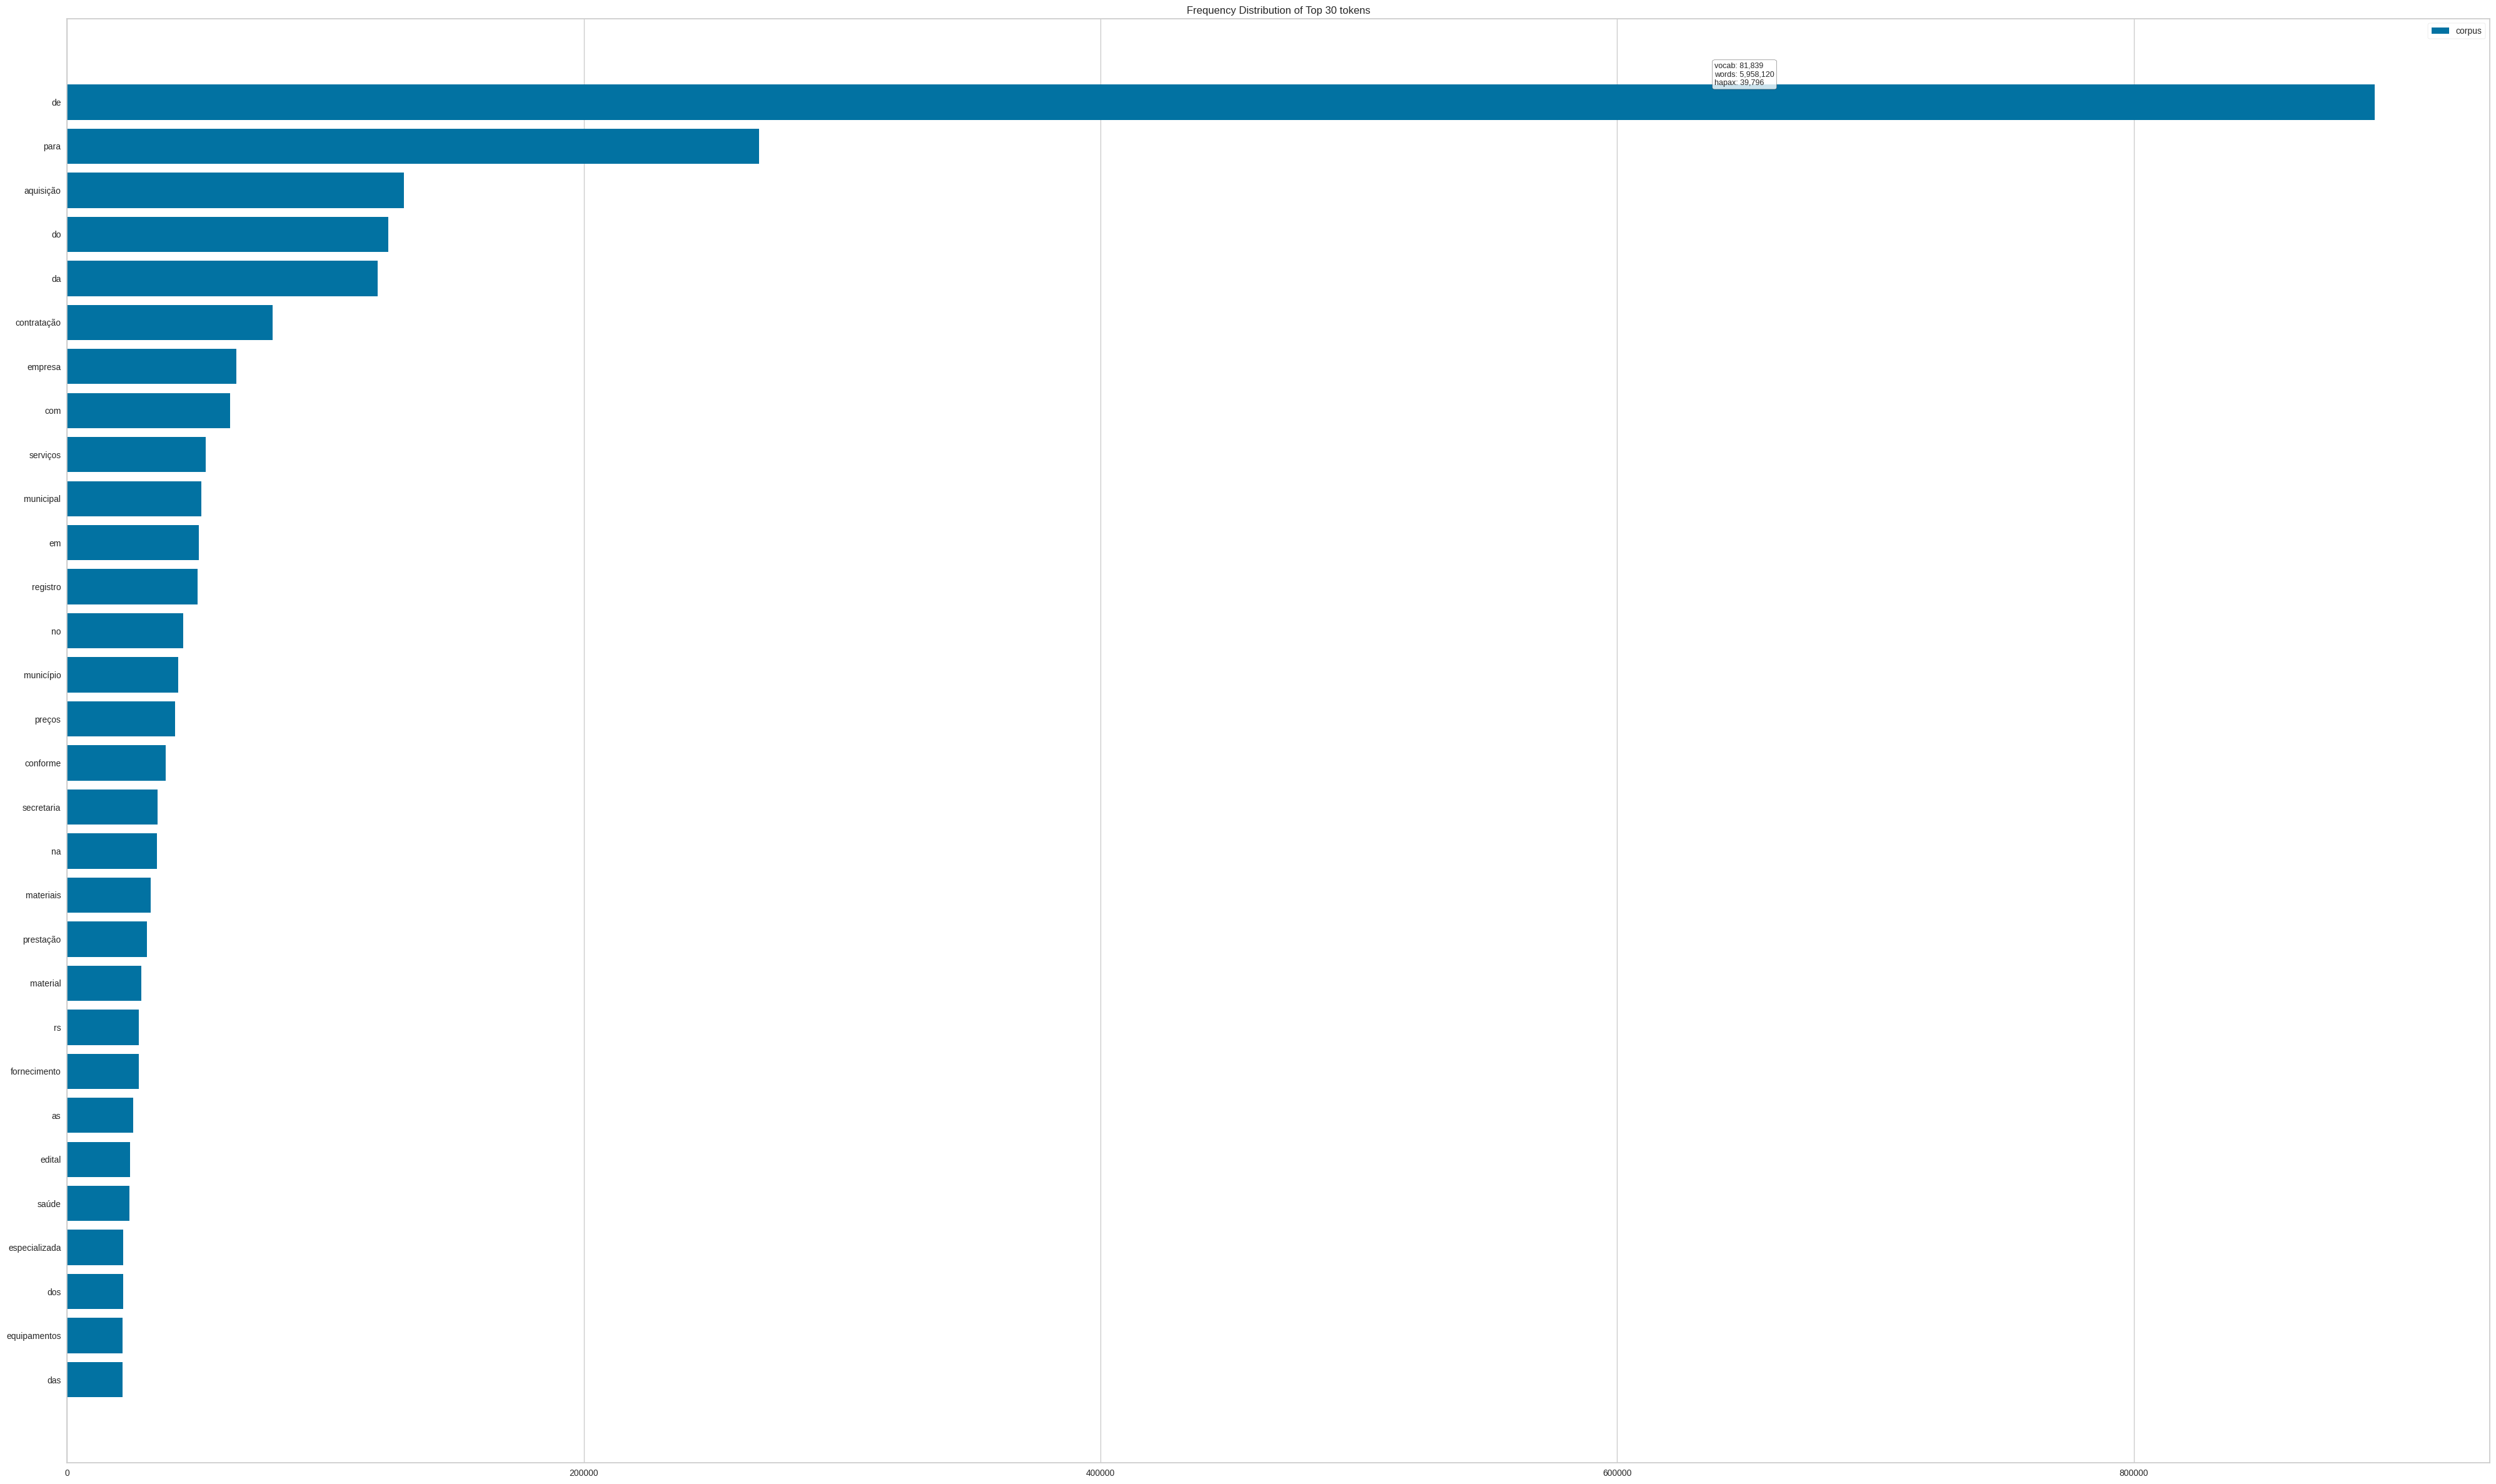

In [22]:
frequencia_palavras(ds_objetos_array, 30, 'h')

## Removing stopwords and cleaning the data:

In [25]:
def remove_stop_words(words):
    stop_words = stopwords.words('portuguese')
    return [word for word in words if word.lower() not in stop_words]

def preprocess(x: AnyStr) -> str:

    special_chars = "¨'!#$%&()*+,./:;<=>?@[\]^_`{|}~"
    new_x = x.replace('"',' ')
    for c in special_chars:
        new_x = new_x.replace(c,' ') # Removes special characters
    new_x = re.sub(r'[^\w\s]', ' ', new_x) # Removes punctuation
    new_x = re.sub("http\S+", ' ',new_x) # Removes links
    new_x = re.sub("@\w+", ' ',new_x) # Removes @
    new_x = re.sub('#\S+', ' ',new_x) # Removes hashtags
    new_x = re.sub('[0-9]+', ' ',new_x) # Removes numbers
    new_x = unidecode(new_x) # Removes accents
    new_x = re.sub("\s+", ' ',new_x) # Removes spaces

    new_x = ' '.join([word for word in new_x.split() if len(word) > 2])
    
    new_x = new_x.strip()
    return new_x

In [6]:
df = df.with_columns(
    pl.col("DS_OBJETO")
    .map_elements(lambda x: nltk.word_tokenize(x.lower(), language='portuguese')) # Tokenize
    .map_elements(lambda x: [preprocess(word) for word in x]) # Other preprocessing
    .map_elements(lambda arr: list(filter(None, arr))) # Removes items with none
    .map_elements(remove_stop_words, return_dtype=pl.List(pl.String)) # Removes stop words
    .alias("DS_OBJETO_NLP")
)

In [7]:
lista_obj = df.select("DS_OBJETO_NLP").collect().to_numpy().flatten()
ds_objetos_array_nlp = np.concatenate(lista_obj).astype(str)

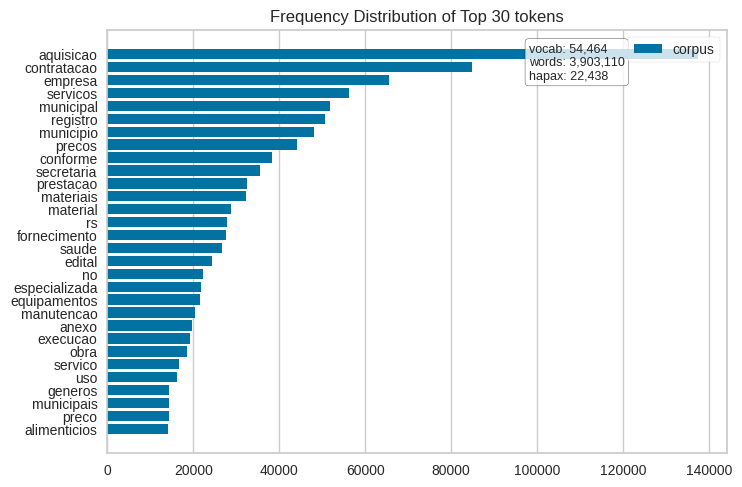

In [8]:
frequencia_palavras(ds_objetos_array_nlp, 30, 'h')

Now let's add more stopwords to remove, in this case, words that contribute little to the clustering, as they are very present in the corpus.

In [6]:
def new_remove_stop_words(words):
    stop_words = stopwords.words("portuguese")
    new_stopwords = [
    "aquisicao",
    "aquisicoes",
    "conforme",
    "contratacao",
    "empresa",
    "servicos",
    "registro",
    "municipal",
    "municipio",
    "precos",
    "secretaria",
    "prestacao",
    "materiais",
    "material",
    "rs",
    "fornecimento",
    "edital",
    "no",
    "especializada",
    "equipamentos",
    "manutencao",
    "anexo",
    "execucao",
    "uso",
    "generos",
    "municipais",
    "preco",
    "ano",
    "mes",
    "dia",
    "anos",
    "meses",
    "dias",
    "kg",
    "especificacoes",
    "secretarias",
    "mao",
    "termo",
    "referencia",
    "licitacao",
    "licitacoes",
    "pregao",
    "sistema",
    "atender",
    "atraves",
    "publica",
    "camara",
    "demais",
    "vereadores",
    "sec",
    "solicitacao",
    "licitatorio",
    "tipo",
    "anexos",
    "anexo",
    'referente',
    'atendimento',
    'utilização',
    'destinados',
    'solicitado',
    'sob',
    'humano',
    'demandas',
    'necessidade',
    'demandar',
    'presente',
    'acordo',
    'outros',
    'parcelada',
    'preços',
    'compra',
    'viacao',
    'legislativo',
    'necessidades',
    'serem',
    'realizacaosecretarias',
    'sendo',
    'solicito',
    'garantia',
    'objeto',
    'futura',
    'diversas',
    'constitui',
    'demanda',
    'diversos',
    'solicitar',
    'constantes',
    'repasse',
    'novos',
    'judicial',
    'prefeitura',
    'emenda',
    'recurso',
    'legislativa',
    'protocolo',
    'deste'
    ]
    new_stopwords.extend(stop_words)


    return [word for word in words if word.lower() not in new_stopwords]


In [7]:
df = df.with_columns(
    pl.col("DS_OBJETO")
    .map_elements(lambda x: nltk.word_tokenize(x.lower(), language='portuguese')) # Tokenize
    .map_elements(lambda x: [preprocess(word) for word in x]) # Other preprocessing
    .map_elements(lambda arr: list(filter(None, arr))) # Removes items with none
    .map_elements(new_remove_stop_words, return_dtype=pl.List(pl.String)) # Removes stop words
    .map_elements(lambda x: [word for word in x if "rs" not in word]) # Remove tokens containing "rs" (which are cities)
    .alias("DS_OBJETO_NLP_NEW")
)

In [8]:
lista_obj_new = df.select("DS_OBJETO_NLP_NEW").collect().to_numpy().flatten()
ds_objetos_array_nlp_new = np.concatenate(lista_obj_new).astype(str)

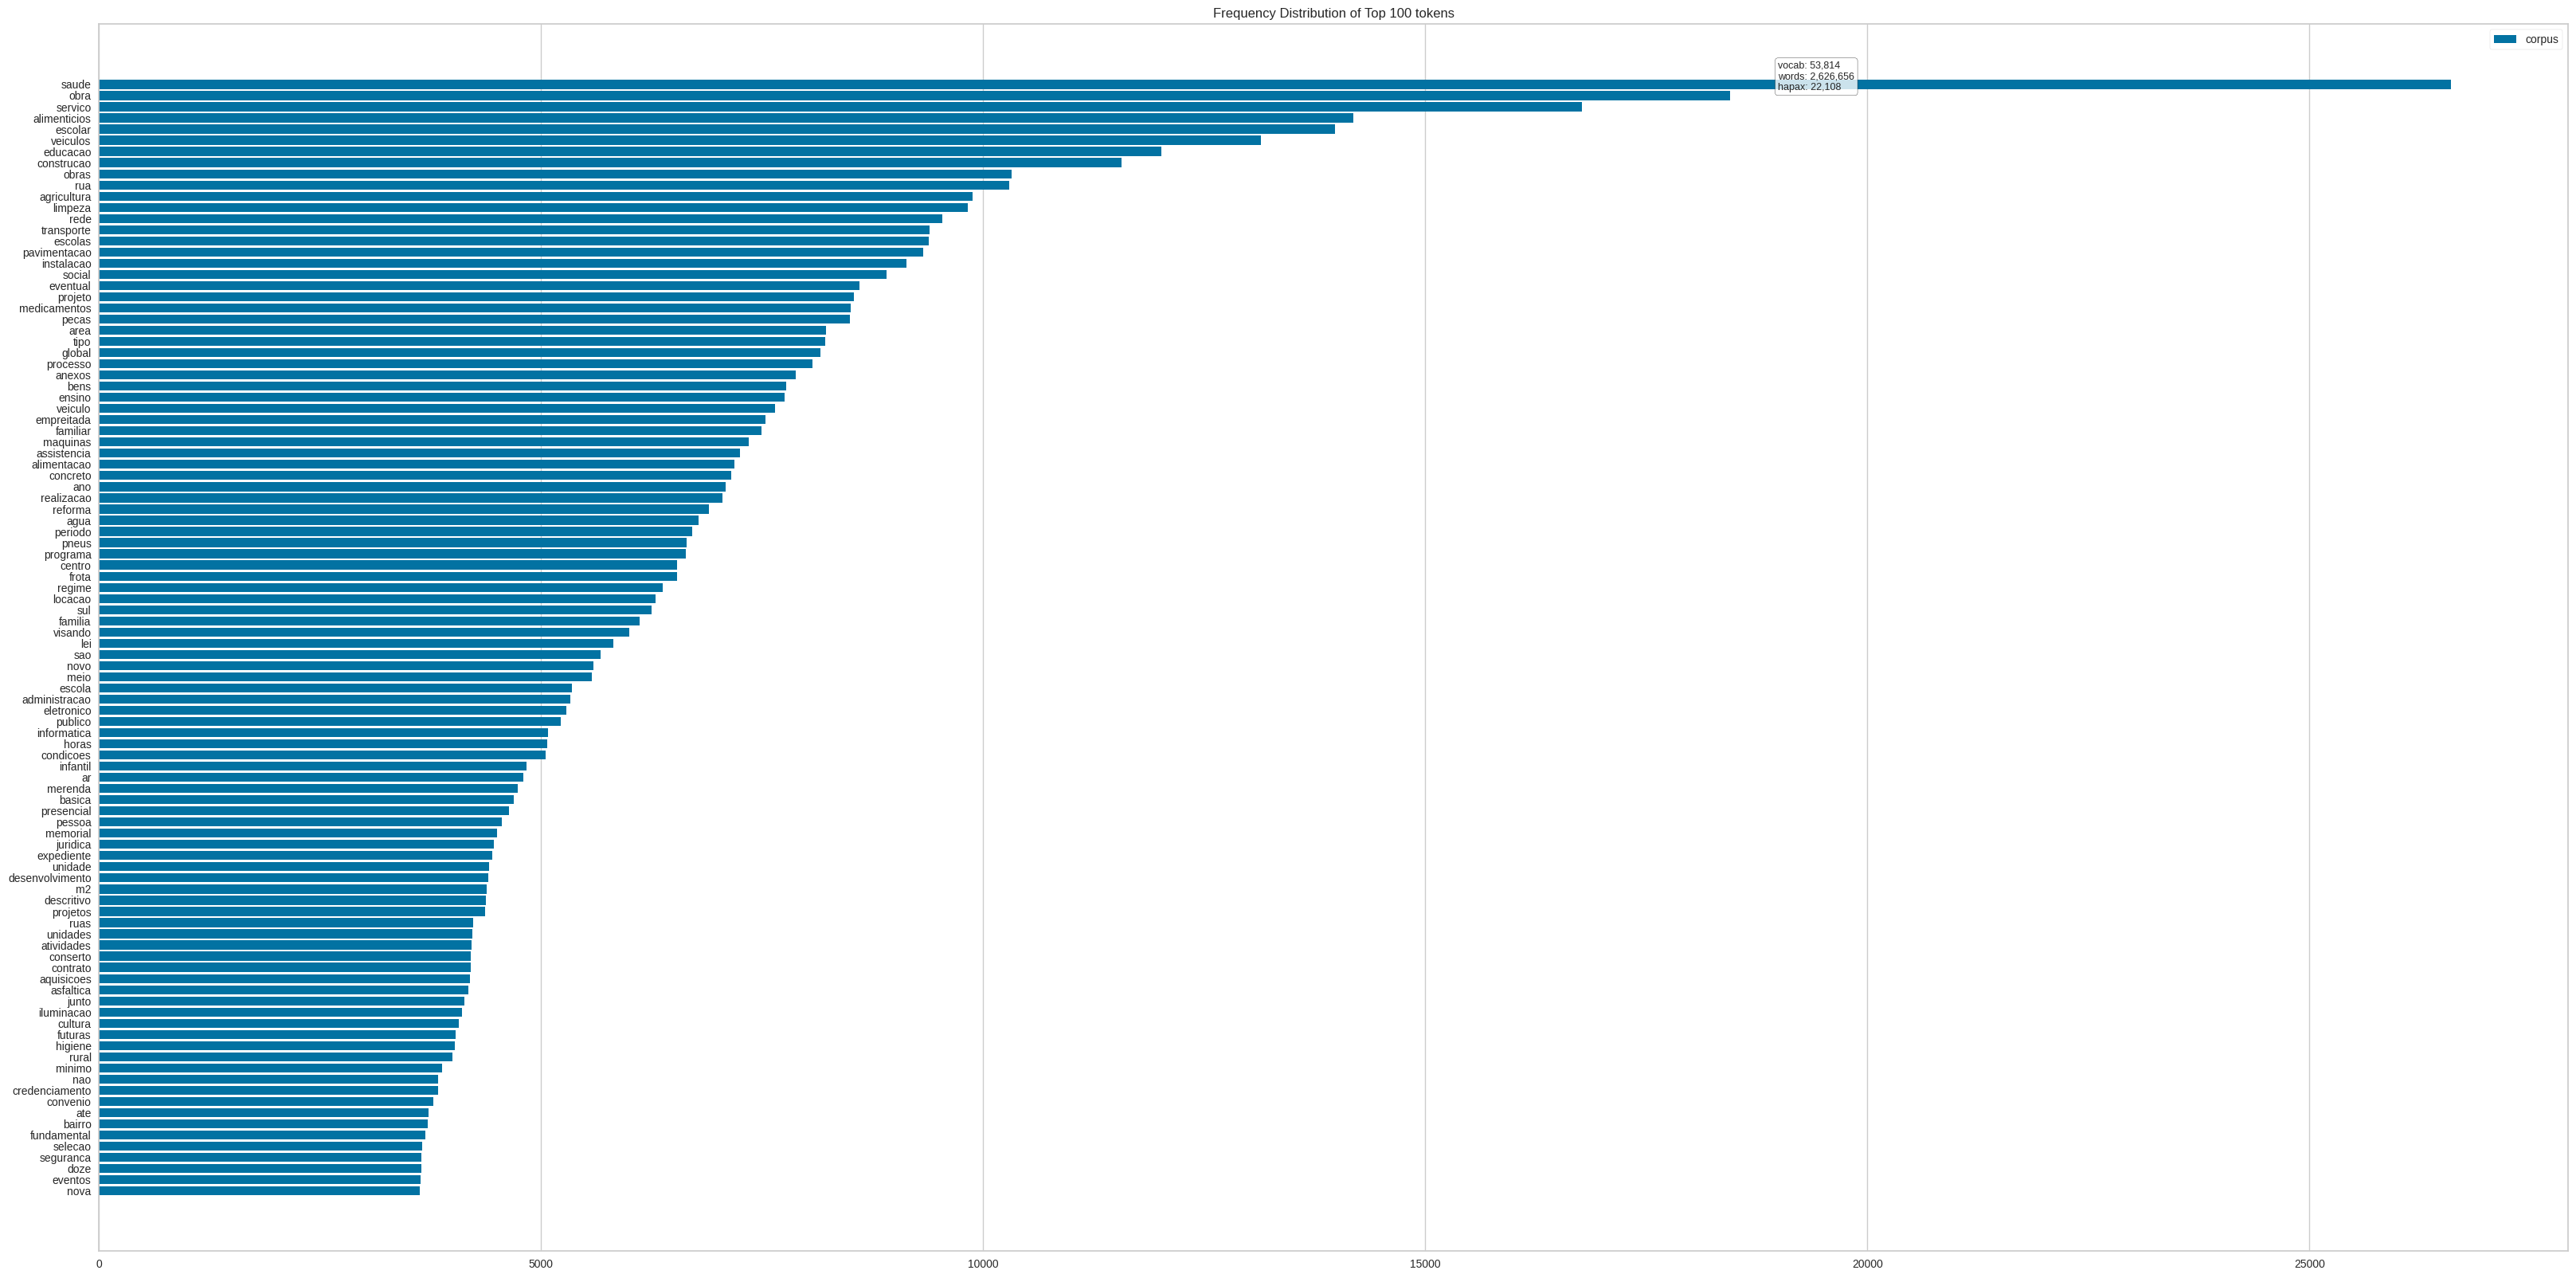

In [24]:
frequencia_palavras(ds_objetos_array_nlp_new, 100, 'h', figsize=(40, 20))

## FALTA VER MAIS STOPWORDS PRA ADICIONAR:

In [ ]:
"eventos",
"nova",
"selecao",
"credenciamento",
"nao",
""

In [13]:
ds_objetos_array_nlp_new[:50]

array(['empresas', 'transporte', 'escolar', 'recapagem', 'pneus',
       'veiculos', 'educacao', 'empreitada', 'global', 'mao de obra',
       'ampliacao', 'reforma', 'predio', 'original', 'esf', 'localizado',
       'av', 'santa', 'rosa', 'lei', 'projeto', 'memorial', 'descritivo',
       'planilha', 'orcamentaria', 'fraldas', 'infantis', 'geriatricas',
       'pacientes', 'aprovados', 'saude', 'gud', 'resolucao', 'cib',
       'produtos', 'merenda', 'escolar', 'alimentacao', 'merenda',
       'escolar', 'escolas', 'disponha', 'profissionais', 'formacao',
       'especifica', 'area', 'minimo', 'nivel', 'mestrado',
       'especialista'], dtype='<U61')

In [14]:
indices_contem_anexo = np.core.defchararray.find(ds_objetos_array_nlp_new.astype(str), "anexo")

# Verificar onde a palavra "anexo" está presente (índices diferentes de -1)
strings_com_anexo = ds_objetos_array_nlp_new[indices_contem_anexo != -1]


In [16]:
strings_com_anexo[:50]

array(['anexos', 'anexos', 'anexos', 'anexos', 'anexos', 'anexos',
       'anexos', 'anexos', 'anexos', 'anexos', 'anexos', 'anexos',
       'anexos', 'anexos', 'anexos', 'anexos', 'anexos', 'anexos',
       'anexos', 'anexos', 'anexos', 'anexos', 'anexos', 'anexo i',
       'anexos', 'anexos', 'anexos', 'anexos', 'anexos', 'anexos',
       'anexos', 'anexos', 'anexos', 'anexos', 'noanexo', 'anexos',
       'anexos', 'anexos', 'anexos', 'anexos', 'anexos', 'anexos',
       'anexos', 'anexos', 'anexos', 'anexos', 'anexos', 'anexos',
       'anexos', 'anexos'], dtype='<U61')